#**Importing Required Libraries**





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.compose import make_column_selector as selector
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# **Loading Required Datasets**

In [2]:
# import network traffic data for each day of the week into dataframes
mon = pd.read_csv(r"C:\Users\LENOVO\Downloads\CNSP22\csv\Monday-WorkingHours.pcap_ISCX.csv")
tue = pd.read_csv(r"C:\Users\LENOVO\Downloads\CNSP22\csv\Tuesday-WorkingHours.pcap_ISCX.csv")
wed = pd.read_csv(r"C:\Users\LENOVO\Downloads\CNSP22\csv\Wednesday-workingHours.pcap_ISCX.csv")
th1 = pd.read_csv(r"C:\Users\LENOVO\Downloads\CNSP22\csv\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
th2 = pd.read_csv(r"C:\Users\LENOVO\Downloads\CNSP22\csv\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
f1 = pd.read_csv(r"C:\Users\LENOVO\Downloads\CNSP22\csv\Friday-WorkingHours-Morning.pcap_ISCX.csv")
f2 = pd.read_csv(r"C:\Users\LENOVO\Downloads\CNSP22\csv\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
f3 = pd.read_csv(r"C:\Users\LENOVO\Downloads\CNSP22\csv\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

# join all the individual dataframes into one
df = pd.concat([f1, f2, f3, th1, th2, wed, tue, mon], axis=0)

df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529913,443,18738,1,1,6,6,6,6,6.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
529914,53,60797,2,2,80,156,40,40,40.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
529915,53,154,2,2,64,96,32,32,32.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
529916,53,155,2,2,80,144,40,40,40.0,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


#**Data Preparation**

## **Cleaning Data**


In [3]:
# dropping duplicate values
df.drop_duplicates(inplace = True)

df.shape

(2522362, 79)

In [4]:
# replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# dropping NaN values
df.dropna(axis=0, inplace=True)

df.shape

(2520798, 79)

In [5]:
# stripping column names
df.rename(columns = lambda x: x.strip(), inplace = True)

df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

## **Data Preprocessing**

In [6]:
# define the mapping
mapping = {
    'BENIGN' : 'BENIGN',
    'DoS Hulk': 'DoS/DDoS',
    'DDoS': 'DoS/DDoS',
    'DoS GoldenEye': 'DoS/DDoS',
    'DoS slowloris': 'DoS/DDoS',
    'DoS Slowhttptest': 'DoS/DDoS',
    'PortScan':'PortScan',
    'Web Attack � Brute Force': 'Brute Force',
    'FTP-Patator' : 'Brute Force',
    'SSH-Patator' : 'Brute Force',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Heartbleed' : 'Web Attack',
    'Infiltration' : 'Bot',
    'Bot': 'Bot'
}

# apply the mapping
df['Label'] = df['Label'].map(mapping).fillna('Other')

df['Label'].value_counts()

Label
BENIGN         2095057
DoS/DDoS        321759
PortScan         90694
Brute Force      10620
Bot               1984
Web Attack         684
Name: count, dtype: int64

## **Data Splitting and Encoding**

In [7]:
# splitting Data into x(independent) and y(dependent)
x = df.iloc[:, :-1]
y = df["Label"]

# convert y to numeric labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# splitting data into training & testing
x_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

# **Training Model**


In [8]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), selector(dtype_exclude="category")),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('label_encoder', LabelEncoder())
        ]), selector(dtype_include="category"))
    ])

# Define the pipeline
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('sampler1', RandomOverSampler()),
    ('sampler', RandomUnderSampler()),
    ('classifier', XGBClassifier(tree_method='hist', device='cuda',objective= 'multi:softmax',  eval_metric = 'mlogloss',  num_class = len(np.unique(y))))
])

pipeline.fit(x, y)

C:\ProgramData\anaconda3\envs\CNSP2\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\ProgramData\anaconda3\envs\CNSP2\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025DBA151010>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('label_encoder',
                                                                   LabelEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=6,
                               num_parallel_tree=None, ...))])

# **Evaluating Model**

In [9]:
# make predictions
preds = pipeline.predict(X_val)

# Evaluate model
accuracy = sum(preds == y_val) / len(y_val)
print("Accuracy:", accuracy)

Accuracy: 0.9863892415106316


# **Saving Model**

In [10]:
# Save the pipeline
joblib.dump(pipeline, 'C:\\Users\\LENOVO\\Downloads\\CNSP22\\xgboost_model_8.pkl')

# Also save label encoder to transform labels back when needed
encoder_filename = "C:\\Users\\LENOVO\\Downloads\\CNSP22\\label_encoder_1.pkl"
joblib.dump(label_encoder, encoder_filename)

['C:\\Users\\LENOVO\\Downloads\\CNSP22\\label_encoder_1.pkl']

# **Plot Training and Validation History**

C:\ProgramData\anaconda3\envs\CNSP2\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\ProgramData\anaconda3\envs\CNSP2\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
C:\ProgramData\anaconda3\envs\CNSP2\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\ProgramData\anaconda3\envs

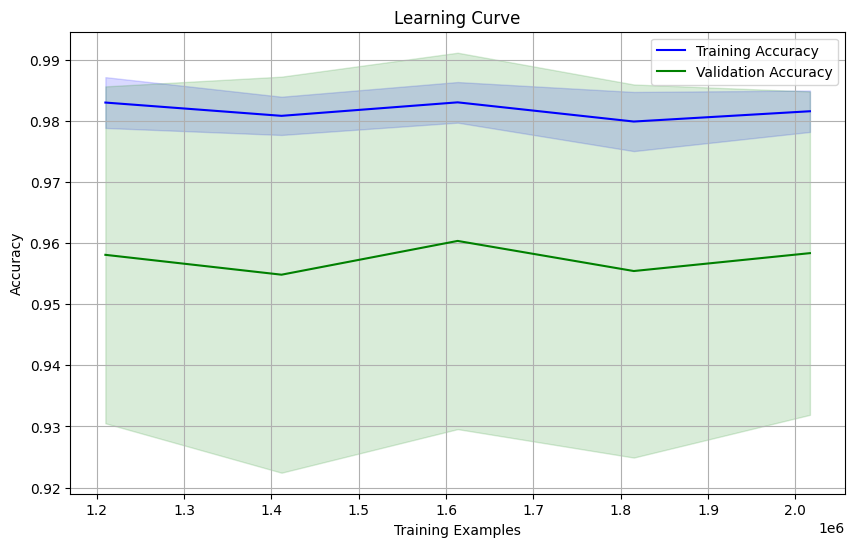

In [11]:
# generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, x, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()
